In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

from utils import votable_to_pandas
from astropy.table import Table

In [2]:
def_last_prob_df = pd.read_csv('out_data/def_last_prob.csv')
def_second_prob_df = pd.read_csv('out_data/def_second_prob.csv')
def_first_prob_df = pd.read_csv('out_data/def_most_prob.csv')

In [3]:
def_first_prob_df_filtered = def_first_prob_df
# Extract unique chandra_source_id values from def_first_prob_df
chandra_ids_in_first = def_first_prob_df_filtered['chandra_source_id'].unique()

# Filter def_second_prob_df and def_last_prob_df based on the extracted chandra_source_id values
filtered_second_prob_df = def_second_prob_df[def_second_prob_df['chandra_source_id'].isin(chandra_ids_in_first)]
filtered_last_prob_df = def_last_prob_df[def_last_prob_df['chandra_source_id'].isin(chandra_ids_in_first)]

In [4]:
df_pos = def_first_prob_df_filtered.query('nway_separation <= 0.2 and parallax == parallax and parallax >= 0')
chandra_ids_in_pos = df_pos['chandra_source_id'].unique()

df_neg= filtered_last_prob_df[filtered_last_prob_df['chandra_source_id'].isin(chandra_ids_in_pos)]

df_pos['flux_aper_b'].replace(0, np.nan, inplace=True)
df_neg['flux_aper_b'].replace(0, np.nan, inplace=True)
df_pos['gmag_logflux'] = df_pos['phot_g_mean_mag'] + np.log10(df_pos['flux_aper_b']/1e-13)*2.5
df_neg['gmag_logflux'] = df_neg['phot_g_mean_mag'] + np.log10(df_neg['flux_aper_b']/1e-13)*2.5

/tmp/ipykernel_309773/4115867806.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['flux_aper_b'].replace(0, np.nan, inplace=True)
/tmp/ipykernel_309773/4115867806.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['flux_aper_b'].replace(0, np.nan, inplace=True)
/tmp/ipykernel_309773/4115867806.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['gmag_logf

/tmp/ipykernel_291760/133061099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos['distance'] = 1 / df_pos['parallax']
/tmp/ipykernel_291760/133061099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg['distance'] = 1 / df_neg['parallax']
/tmp/ipykernel_291760/133061099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

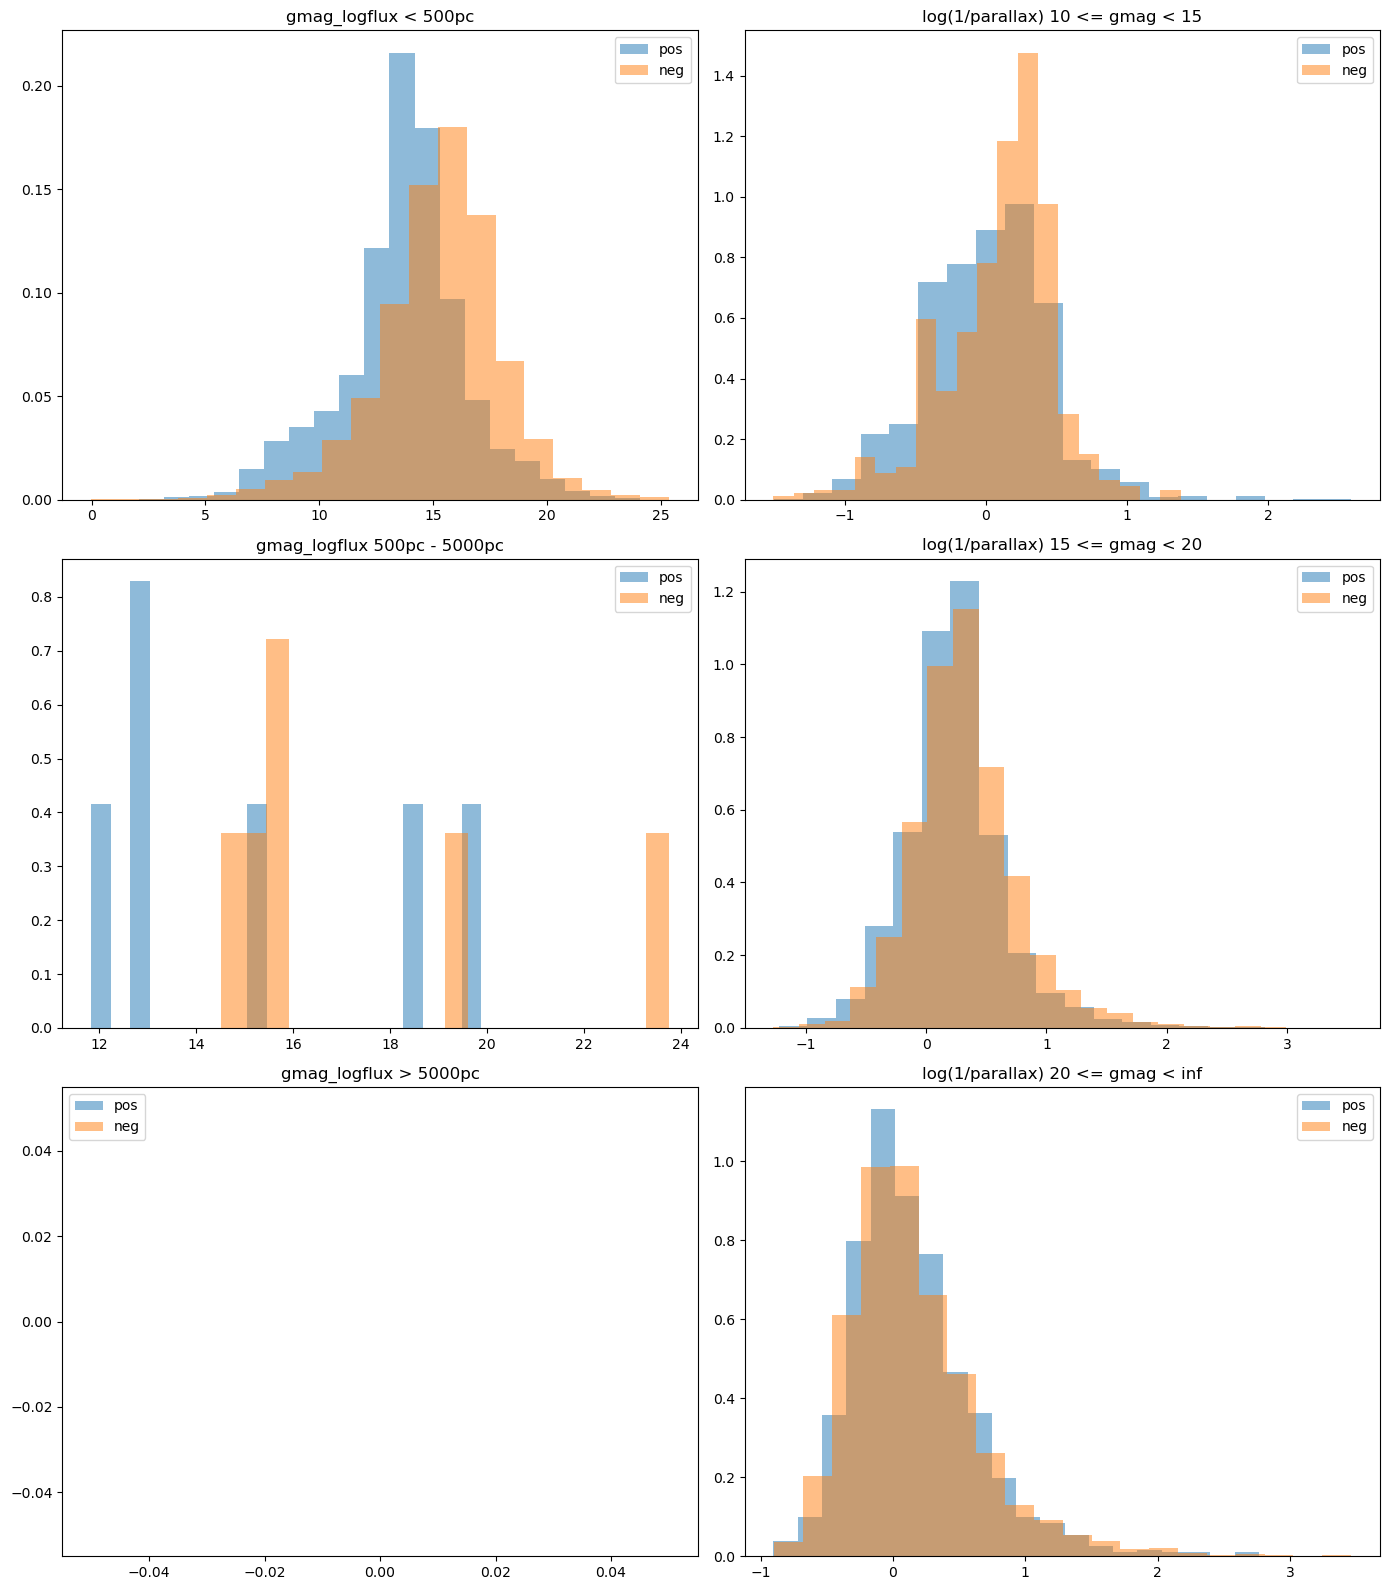

In [18]:
# distances
df_pos['distance'] = 1 / df_pos['parallax']
df_neg['distance'] = 1 / df_neg['parallax']

# Calculate log(1/plx)
df_pos['log_inv_plx'] = np.log10(1 / df_pos['parallax'])
df_neg['log_inv_plx'] = np.log10(1 / df_neg['parallax'])

# Plot settings
bins = 20

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(14, 16))

# Plot for gmag_logflux < 500pc
axs[0, 0].hist(df_pos[df_pos['distance'] < 500]['gmag_logflux'], bins=bins, alpha=0.5, label='pos', density=True)
axs[0, 0].hist(df_neg[df_neg['distance'] < 500]['gmag_logflux'], bins=bins, alpha=0.5, label='neg', density=True)
axs[0, 0].set_title('gmag_logflux < 500pc')
axs[0, 0].legend()

# Plot for 500pc <= gmag_logflux <= 5000pc
axs[1, 0].hist(df_pos[(df_pos['distance'] >= 500) & (df_pos['distance'] <= 5000)]['gmag_logflux'], bins=bins, alpha=0.5, label='pos', density=True)
axs[1, 0].hist(df_neg[(df_neg['distance'] >= 500) & (df_neg['distance'] <= 5000)]['gmag_logflux'], bins=bins, alpha=0.5, label='neg', density=True)
axs[1, 0].set_title('gmag_logflux 500pc - 5000pc')
axs[1, 0].legend()

# Plot for gmag_logflux > 5000pc
axs[2, 0].hist(df_pos[df_pos['distance'] > 5000]['gmag_logflux'], bins=bins, alpha=0.5, label='pos', density=True)
axs[2, 0].hist(df_neg[df_neg['distance'] > 5000]['gmag_logflux'], bins=bins, alpha=0.5, label='neg', density=True)
axs[2, 0].set_title('gmag_logflux > 5000pc')
axs[2, 0].legend()

# Plot for undefined/negative distances (log_inv_plx for gmag of 10-15, 15-20, >20)
for i, (gmag_lower, gmag_upper) in enumerate([(10, 15), (15, 20), (20, float('inf'))]):
    axs[i, 1].hist(df_pos[(df_pos['phot_g_mean_mag'] >= gmag_lower) & (df_pos['phot_g_mean_mag'] < gmag_upper)]['log_inv_plx'], bins=bins, alpha=0.5, label='pos', density=True)
    axs[i, 1].hist(df_neg[(df_neg['phot_g_mean_mag'] >= gmag_lower) & (df_neg['phot_g_mean_mag'] < gmag_upper)]['log_inv_plx'], bins=bins, alpha=0.5, label='neg', density=True)
    axs[i, 1].set_title(f'log(1/parallax) {gmag_lower} <= gmag < {gmag_upper}')
    axs[i, 1].legend()

plt.tight_layout()
plt.savefig('figures/chandra_gaia_nway_exp/distributions_strat_vinay.pdf')


In [5]:
df_all = pd.concat([df_pos, df_neg], ignore_index=True)

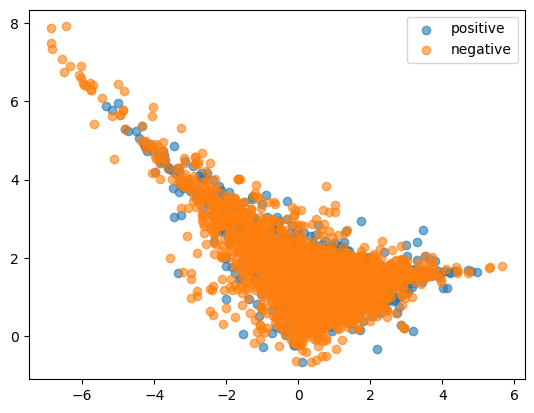

In [6]:
plt.scatter(df_pos['bp_g'],df_pos['g_rp'],alpha=0.6, label='positive')
plt.scatter(df_neg['bp_g'],df_neg['g_rp'],alpha=0.6, label='negative')
plt.legend()

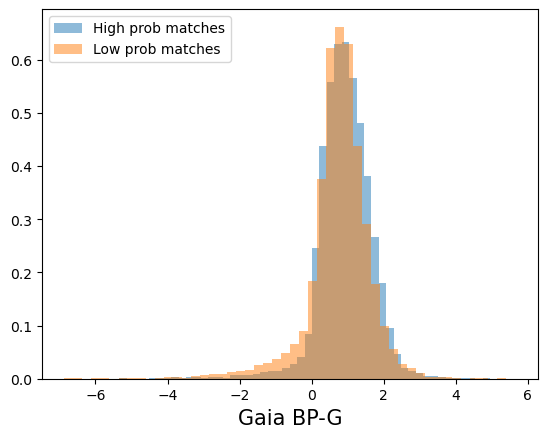

In [22]:
plt.hist(df_pos['bp_g'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_neg['bp_g'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-G',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_G.pdf',dpi=300)

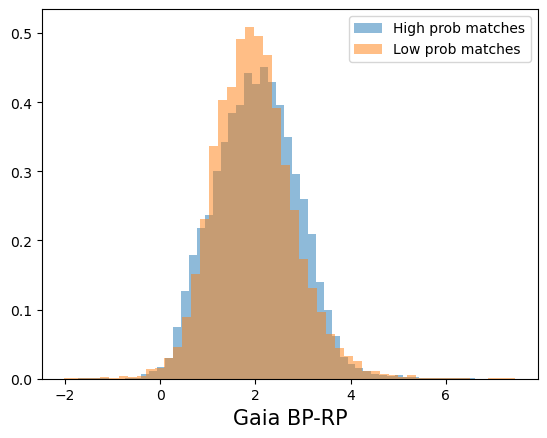

In [23]:
plt.hist(df_pos['bp_rp'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_neg['bp_rp'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia BP-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_BP_RP.pdf',dpi=300)

/home/ubunsam/miniconda3/envs/starsml/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


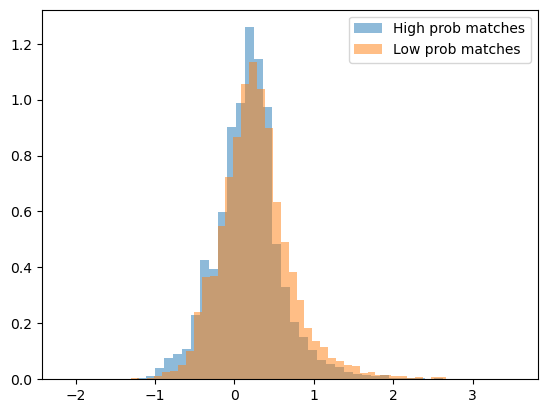

In [24]:
plt.hist(np.log10(1/df_pos['parallax']),bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(np.log10(1/df_neg['parallax']),bins=50,alpha=0.5,density=True,label='Low prob matches')
#plt.xlabel('Gaia G-RP',size=15)
plt.legend()
#plt.savefig('figures/Gaia_G_RP.pdf',dpi=300)

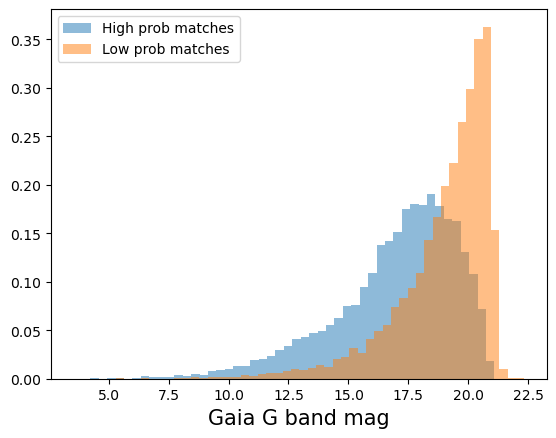

In [25]:
plt.hist(df_pos['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='High prob matches')
plt.hist(df_neg['phot_g_mean_mag'],bins=50,alpha=0.5,density=True,label='Low prob matches')
plt.xlabel('Gaia G band mag',size=15)
#plt.xscale('log')
plt.legend()
#plt.savefig('figures/Gaia_G_mag.pdf',dpi=300)

---
#### Preprocessing

In [7]:
feature_names = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp', 'parallax', 'parallax_over_error',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'flux_aper_b',
    'gmag_logflux'
]

# List of features to skip for the log transformation
skip_log_features = [ 
    'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'bp_rp', 'bp_g', 'g_rp',
    'hard_hs',
    'hard_hm',
    'hard_ms',
    'var_intra_prob_b',
    'var_inter_prob_b',
    'gmag_logflux'
]

from utils import preprocess, transform_features, handle_missing_values, standardize

In [8]:
# Preprocess the data
X, Y = preprocess(df_pos, df_neg, feature_names, skip_log_features)
indices = np.arange(X.shape[0])

# Split into training and test sets
(X_train, 
 X_test, 
 Y_train, 
 Y_test, 
 indices_train, 
 indices_test) = train_test_split(X, Y, indices, test_size=0.3, shuffle=True)

# Handle missing values
X_train, X_test, imp_mean = handle_missing_values(X_train, X_test)

# Standardize
#X_train, X_test, scaler = standardize(X_train, X_test)

/mnt/d/workspace/starsml/utils.py:8: RuntimeWarning: invalid value encountered in log10
  np.log10(1 + df[feature].values) if feature not in skip_log_features else df[feature].values


In [9]:
from collections import Counter

def class_proportions(y):
    counts = Counter(y)
    total = len(y)
    proportions = {key: value / total for key, value in counts.items()}
    return proportions

train_proportions = class_proportions(Y_train)
test_proportions = class_proportions(Y_test)

print("Training proportions:", train_proportions)
print("Test proportions:", test_proportions)

Training proportions: {1.0: 0.5008770220229974, 0.0: 0.49912297797700256}
Test proportions: {1.0: 0.4979536152796726, 0.0: 0.5020463847203275}


In [10]:
num_samples = X.shape[0]
nan_count_per_feature = np.isnan(X).sum(axis=0)

# Calculate the percentage for each feature
nan_percentage_per_feature = (nan_count_per_feature / num_samples) * 100

for i, percentage in enumerate(nan_percentage_per_feature):
    print(f"Percentage of NaN values in feature {feature_names[i]}: {percentage:.2f}%")


Percentage of NaN values in feature phot_g_mean_mag: 0.47%
Percentage of NaN values in feature phot_bp_mean_mag: 8.68%
Percentage of NaN values in feature phot_rp_mean_mag: 7.50%
Percentage of NaN values in feature bp_rp: 8.74%
Percentage of NaN values in feature bp_g: 8.68%
Percentage of NaN values in feature g_rp: 7.91%
Percentage of NaN values in feature parallax: 11.43%
Percentage of NaN values in feature parallax_over_error: 12.50%
Percentage of NaN values in feature hard_hs: 21.30%
Percentage of NaN values in feature hard_hm: 21.02%
Percentage of NaN values in feature hard_ms: 21.62%
Percentage of NaN values in feature var_intra_prob_b: 18.23%
Percentage of NaN values in feature var_inter_prob_b: 47.16%
Percentage of NaN values in feature flux_aper_b: 22.05%
Percentage of NaN values in feature gmag_logflux: 22.42%


---
#### Baseline Models

In [11]:
# Model Building
clf_rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=4)
clf_rf.fit(X_train, Y_train)

# Predictions
y_pred_rf = clf_rf.predict(X_test)
y_pred_rf_prob = clf_rf.predict_proba(X_test)[:, 1]  # for AUC

# Evaluation
print(f"RF train accuracy: {clf_rf.score(X_train, Y_train):.3f}")
print("Accuracy:", accuracy_score(Y_test, y_pred_rf))
print("Precision:", precision_score(Y_test, y_pred_rf))
print("Recall:", recall_score(Y_test, y_pred_rf))
print("F1 Score:", f1_score(Y_test, y_pred_rf))
print("AUC-ROC:", roc_auc_score(Y_test, y_pred_rf_prob))

# Check Scalar and Missing Values
# Error Analysis (check distances of matches in errors)

RF train accuracy: 0.939
Accuracy: 0.7771714415643475
Precision: 0.740843949044586
Recall: 0.8497716894977169
F1 Score: 0.7915780518928116
AUC-ROC: 0.8575781146598502


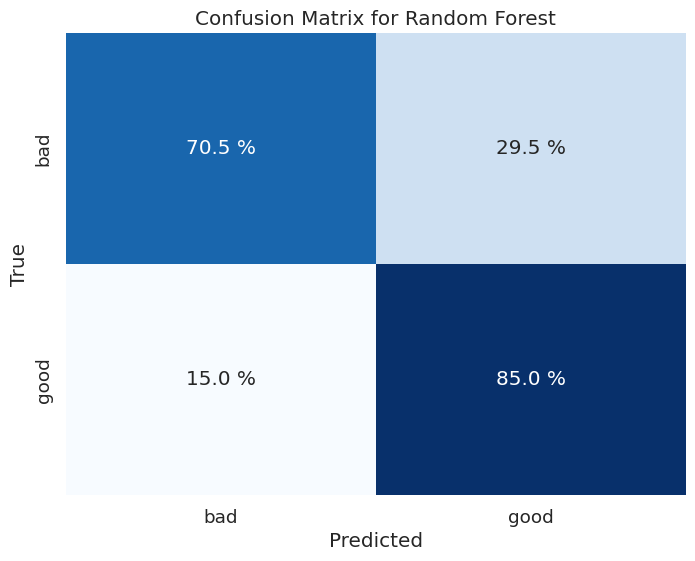

In [12]:
# Compute the confusion matrix and normalize it to get percentages
cm = confusion_matrix(Y_test, y_pred_rf, normalize='true')

# Multiply by 100 to get percentages and round to 1 decimal place
cm_percentage = (cm * 100).round(1)

# Define the class labels
class_labels = ['bad', 'good']

# Create a Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) # Adjust to your preference
sns.heatmap(cm_percentage, annot=True, fmt='', cmap='Blues', cbar=False, 
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={'va':'center'},
            )

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Random Forest')

# Iterate through the heatmap to add the '%' sign to the annotations
for t in plt.gca().texts:
    t.set_text(t.get_text() + " %")

plt.savefig('figures/chandra_gaia_nway_exp/confusion_rf_.png', dpi=300)

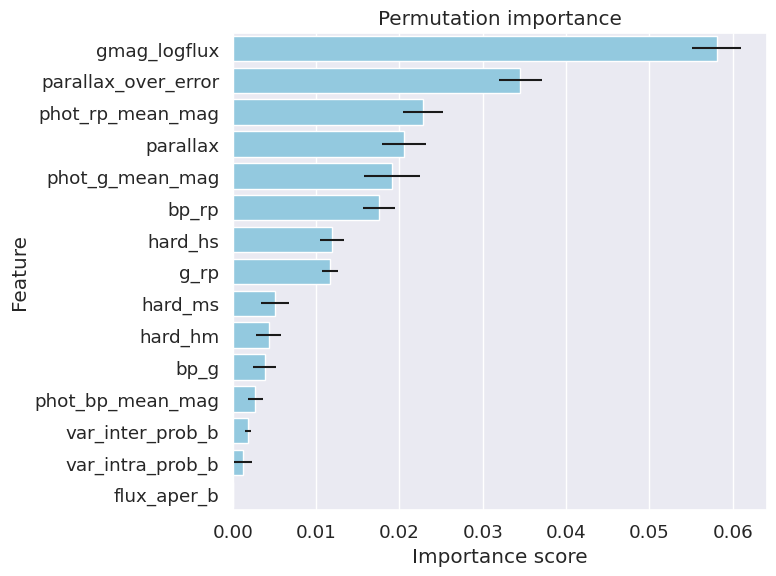

In [32]:
# Calculate permutation importances
per_importances = permutation_importance(
    clf_rf, X_test, Y_test, n_repeats=10, random_state=42, n_jobs=2
)

# Sort the features by importance in descending order
sorted_idx = per_importances.importances_mean.argsort()[::-1]

# Create a Pandas DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': np.array(feature_names)[sorted_idx],
    'Importance': per_importances.importances_mean[sorted_idx],
    'Importance_std': per_importances.importances_std[sorted_idx]
})

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, color='skyblue', errorbar=None, capsize=.1, xerr=importance_df['Importance_std'])

# Add labels and title
plt.title("Permutation importance")
plt.xlabel("Importance score")
plt.tight_layout()

In [13]:
# Sample dataframes (replace these with your real df_train, df_test, df_totest)
df_train = df_all.iloc[indices_train]
df_train['prediction'] = clf_rf.predict(X_train)
df_train['actual'] = Y_train
y_train_rf_prob = clf_rf.predict_proba(X_train)[:, 1]

df_test = df_all.iloc[indices_test]
df_test['prediction'] = y_pred_rf
df_test['actual'] = Y_test

# List of dataframes and their names
dfs = [df_train, df_test]
names = ['Train', 'Test']

features = feature_names

/tmp/ipykernel_309773/3311305092.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['prediction'] = clf_rf.predict(X_train)
/tmp/ipykernel_309773/3311305092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['actual'] = Y_train
/tmp/ipykernel_309773/3311305092.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

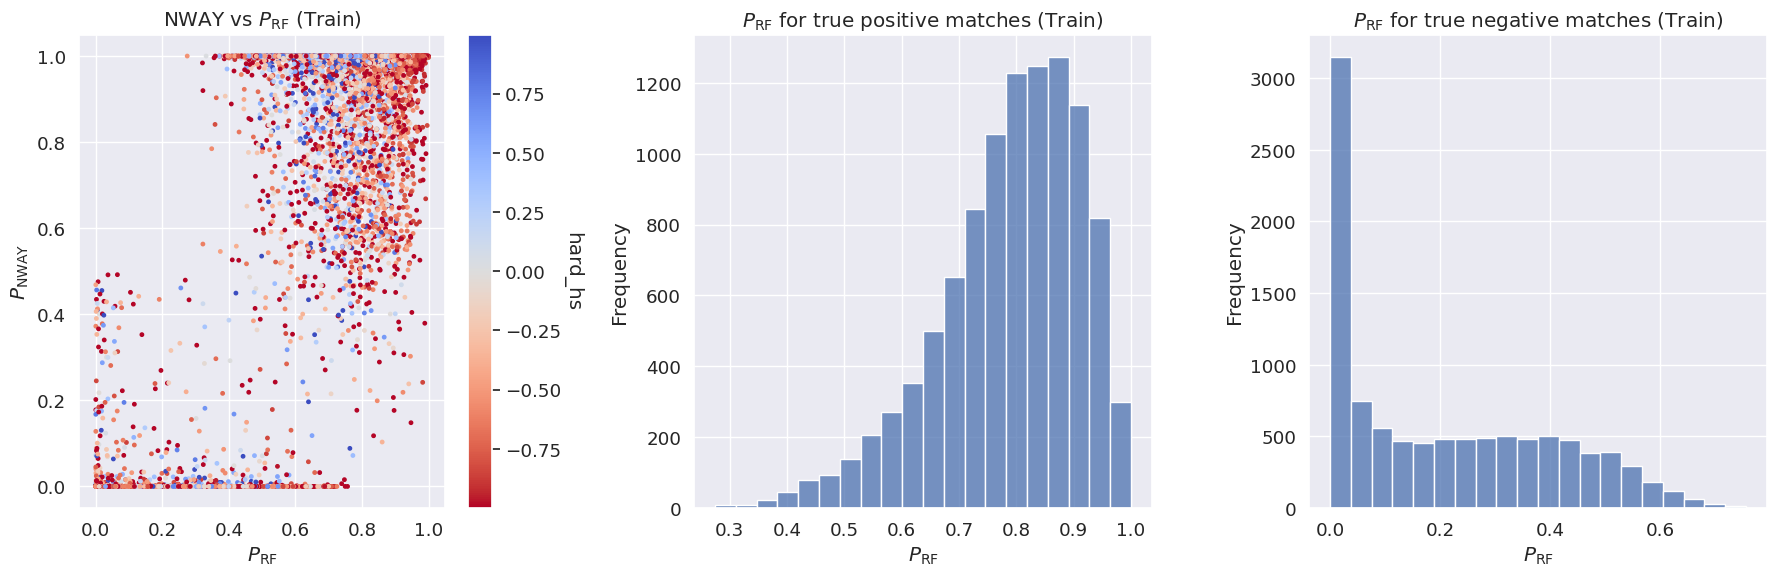

In [15]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('figures/chandra_gaia_nway_exp/histograms_probs.pdf') as pdf:
    # Plot for each dataset
    for dataset, pred_prob, title in zip([df_train, df_test], 
                                        [y_train_rf_prob, y_pred_rf_prob], 
                                        ['Train', 'Test']):
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        
        # Scatter Plot
        cmap = 'coolwarm_r'
        norm = plt.Normalize(dataset['hard_hs'].min(), dataset['hard_hs'].max())
        sc = ax[0].scatter(pred_prob, dataset['p_i'], 
                        c=dataset['hard_hs'], cmap=cmap, norm=norm, s=6)
        cbar = plt.colorbar(sc, ax=ax[0])
        cbar.set_label('hard_hs', rotation=270, labelpad=15)
        ax[0].set_title(r'NWAY vs $P_{\mathrm{RF}}$ (%s)' % title)
        ax[0].set_ylabel(r'$P_{\mathrm{NWAY}}$')
        ax[0].set_xlabel(r'$P_{\mathrm{RF}}$')
        
        # Histogram: Our Probabilities (Predicted Good)
        sns.histplot(pred_prob[dataset.actual == 1], bins=20, kde=False, ax=ax[1])
        ax[1].set_title(r'$P_{\mathrm{RF}}$ for true positive matches (%s)' % title)
        ax[1].set_xlabel(r'$P_{\mathrm{RF}}$')
        ax[1].set_ylabel('Frequency')
        
        # Histogram: Our Probabilities (Predicted Bad)
        sns.histplot(pred_prob[dataset.actual == 0], bins=20, kde=False, ax=ax[2])
        ax[2].set_title(r'$P_{\mathrm{RF}}$ for true negative matches (%s)' % title)
        ax[2].set_xlabel(r'$P_{\mathrm{RF}}$')
        ax[2].set_ylabel('Frequency')
        
        plt.tight_layout()
        pdf.savefig(fig); 
plt.close();